In [ ]:
#This is an attempt to forecast stck prices using an encoder-decoder architecture

In [1]:
#Import all the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from trading_tools import data_frame
from tqdm import tqdm
import time

In [2]:
ASSET = "AUDCAD_otc" 
# ASSET = "EURUSD_otc" 
df = data_frame.load_csv(f"actives/ACTIVO-{ASSET}-0005s.csv")

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
scaler=MinMaxScaler(feature_range=(1,10))

In [5]:
scaled_data=scaler.fit_transform(df)

In [6]:
scaled_data.shape

(909722, 4)

In [7]:
scaled_df=pd.DataFrame(scaled_data, columns=df.columns, index=df.index)
scaled_df

,open,high,low,close
time,,,,
2024-10-21 01:03:10,8.027220,8.025903,8.030172,8.028701
2024-10-21 01:03:15,8.026557,8.026234,8.026194,8.028369
2024-10-21 01:03:20,8.025231,8.023913,8.026194,8.027043
2024-10-21 01:03:25,8.023905,8.029550,8.028515,8.032017
2024-10-21 01:03:30,8.029541,8.034856,8.034151,8.038649
...,...,...,...,...
2024-12-12 16:36:05,1.750856,1.748452,1.752653,1.750718
2024-12-12 16:36:10,1.748536,1.745136,1.745690,1.746408
2024-12-12 16:36:15,1.744889,1.748121,1.748342,1.753040


In [30]:
n = len(scaled_df)
scaled_df["target"] = scaled_df['close'].shift(-6)
scaled_df.dropna(inplace=True)
train_df = scaled_df[0         :int(n*0.7)]
val_df   = scaled_df[int(n*0.7):int(n*0.9)]
test_df  = scaled_df[int(n*0.9):          ]

In [12]:
#This is a function from the book "Advances in Financial Machine Learning" by Marco Lopes De Prado
#It checks for how the data's underlying distribution and it's mean and variance changes.
#Since most ML methods assume stationarity in data, this is a crucial check
#Implementing the Dickey-Fuller test here.

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

def test_stationarity(x):


    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plt.plot(x, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
        
        if result[0]>value:
            print("The graph is non stationery")
            break
        else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))

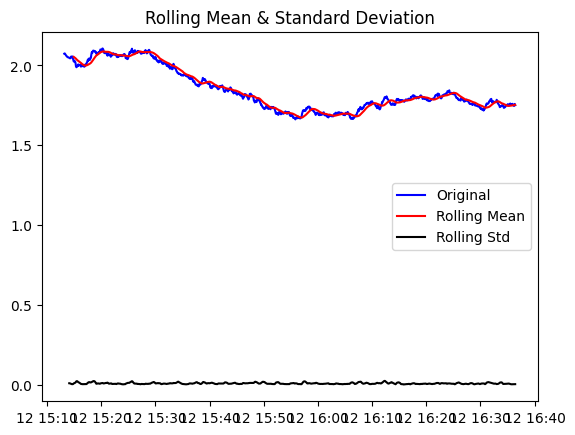

ADF Stastistic: -1.572233
p-value: 0.497525
The graph is non stationery
Critical values:
	1%: -3.437 
	5%: -2.864 
	10%: -2.568 


In [13]:
test_stationarity(scaled_df.iloc[-1000:]["close"])

In [101]:
class WindowGenerator():
    def __init__(self, input_width, label_columns, features_columns,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                  batch_size=32):
        # Almacenar los datos crudos
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.label_columns = label_columns     
           
        self.features_columns = features_columns
        

        # Calcular los parámetros de la ventana
        self.input_width = input_width

        self.total_window_size = input_width 

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.batch_size = batch_size
        self.normalize_inputs = False

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {min(self.input_indices)} - {max(self.input_indices)}',
            f'Label column name(s): {self.label_columns}',
            f'Feature column name(s): {self.features_columns}'
        ])
    
    @tf.function
    def normalize(self, inputs):
        def normalize_sequence(sequence):
            rolling_mean = tf.reduce_mean(sequence, axis=0, keepdims=True)
            return (sequence - rolling_mean) / rolling_mean

        return tf.map_fn(normalize_sequence, inputs, fn_output_signature=tf.float32)

    def split_window(self, features):
        data = features[:, self.input_slice, :]
        inputs = tf.stack([data[:, :, self.column_indices[name]] for name in self.features_columns], axis=-1)
        labels = tf.stack([data[:, -1, self.column_indices[name]] for name in self.label_columns], axis=-1)
        # decoder_input = tf.stack([data[:, :, self.column_indices[name]] * 0 for name in self.features_columns], axis=-1)
        # if self.normalize_inputs:
        #     inputs = self.normalize(tf.cast(inputs, tf.float32))  # Convertir inputs a float32

        inputs.set_shape([None, self.input_width, len(self.features_columns)])
        # decoder_input.set_shape([None, self.input_width, len(self.features_columns)])
        labels.set_shape([None, len(self.label_columns)])
        # decoder_input.set_shape([self.input_width, 1])

        # decoder_input = np.zeros((inputs.shape[0], inputs.shape[1], 1))
        # print(inputs.shape)
        # decoder_input = np.zeros((self.batch_size, inputs.shape[1], 1))
        
        # return [inputs, decoder_input], labels
        return inputs, labels

    def make_dataset(self, data):
        data = data.to_numpy()
        ds = keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=self.batch_size
        )
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            # No se encontró un lote de ejemplo, así que obtén uno del dataset de entrenamiento
            result = next(iter(self.train))
            # Y guárdalo en caché para la próxima vez
            self._example = result
        return result


In [15]:
scaled_df.isnull().values.any()

False

In [ ]:
#Finally we get to the model architecture part.
layers=[256,512,512,256]
learning_rate=0.01
decay=0
optimiser = keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=decay) 
num_input_features=4
num_output_features=1

loss="mse"
lambda_regulariser = 0.000001
regulariser=keras.regularizers.l2(lambda_regulariser)
#batch_size=104
steps_per_epoch=2
epochs=5000

input_sequence_length=5
target_sequence_length=3
num_steps_to_predict=3

In [33]:
encoder_inputs = keras.layers.Input(shape=(None, num_input_features))
#activation1=keras.layers.LeakyReLU()

# Create a list of RNN Cells, these are then concatenated into a single layer
# with the RNN layer.
encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                               dropout=0.25,
                                               recurrent_dropout=0.5,
                                               activation='relu',
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))
    #encoder_cells.append(keras.layers.LeakyReLU(alpha=0.1))

encoder = keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

# Discard encoder outputs and only keep the states.
# The outputs are of no interest to us, the encoder's
# job is to create a state describing the input sequence.
encoder_states = encoder_outputs_and_states[1:]

In [35]:
model2= keras.models.Model(inputs=[encoder_inputs, decoder_in], outputs=decoder_outputs)
model2.compile(optimizer=optimiser, loss=loss)


In [102]:
label_columns=["target"]
# features_columns=['open', "close"]
features_columns= [col for col in df.columns if col not in label_columns]
num_labels = len(label_columns)
num_features = len(features_columns)
input_width = 15

window = WindowGenerator( input_width=input_width, label_columns= label_columns , features_columns=features_columns, batch_size=2048)

window

Total window size: 15
Input indices: 0 - 14
Label column name(s): ['target']
Feature column name(s): ['open', 'high', 'low', 'close']

In [103]:
window.example[0]

<tf.Tensor: shape=(2048, 15, 4), dtype=float64, numpy=
array([[[8.02722016, 8.02590273, 8.03017241, 8.02870091],
        [8.02655715, 8.02623434, 8.02619363, 8.02836932],
        [8.02523113, 8.02391304, 8.02619363, 8.02704296],
        ...,
        [8.02688865, 8.03551953, 8.03149867, 8.03997495],
        [8.03683377, 8.03817244, 8.04111406, 8.04163289],
        [8.03716527, 8.04115696, 8.04144562, 8.04561197]],

       [[8.02655715, 8.02623434, 8.02619363, 8.02836932],
        [8.02523113, 8.02391304, 8.02619363, 8.02704296],
        [8.02390512, 8.02955048, 8.02851459, 8.0320168 ],
        ...,
        [8.03683377, 8.03817244, 8.04111406, 8.04163289],
        [8.03716527, 8.04115696, 8.04144562, 8.04561197],
        [8.04048031, 8.04314665, 8.04509284, 8.04428561]],

       [[8.02523113, 8.02391304, 8.02619363, 8.02704296],
        [8.02390512, 8.02955048, 8.02851459, 8.0320168 ],
        [8.02954068, 8.0348563 , 8.03415119, 8.03864859],
        ...,
        [8.03716527, 8.04115696,

In [97]:


# Definir los parámetros del modelo
layers = [256, 512, 512, 256]
learning_rate = 0.01
decay = 0
optimiser = keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=decay)
num_input_features = 4
num_output_features = 1
loss = "mse"
lambda_regulariser = 0.000001
regulariser = keras.regularizers.l2(lambda_regulariser)
steps_per_epoch = 2
epochs = 5000

# Crear una capa personalizada para dividir la entrada
class SplitInputLayer(keras.layers.Layer):
    def __init__(self, num_output_features, **kwargs):
        super(SplitInputLayer, self).__init__(**kwargs)
        self.num_output_features = num_output_features

    def call(self, inputs):
        encoder_input = inputs[:, :, :self.num_output_features]
        decoder_input = tf.zeros_like(encoder_input)
        return [encoder_input, decoder_input]

# Crear las capas del encoder
encoder_inputs = keras.layers.Input(shape=(15, num_input_features))
split_layer = SplitInputLayer(num_output_features)(encoder_inputs)
encoder_cells = [keras.layers.LSTMCell(hidden_neurons, 
                                       dropout=0.25, 
                                       recurrent_dropout=0.5, 
                                       activation='relu', 
                                       kernel_regularizer=regulariser, 
                                       recurrent_regularizer=regulariser, 
                                       bias_regularizer=regulariser) 
                 for hidden_neurons in layers]
encoder = keras.layers.RNN(encoder_cells, return_state=True)
encoder_outputs_and_states = encoder(split_layer[0])
encoder_states = encoder_outputs_and_states[1:]  # Solo conservamos los estados

# Crear las capas del decoder
decoder_in = split_layer[1]
decoder_cells = [keras.layers.LSTMCell(hidden_neurons, 
                                       dropout=0.25, 
                                       recurrent_dropout=0.5, 
                                       activation='relu', 
                                       kernel_regularizer=regulariser, 
                                       recurrent_regularizer=regulariser, 
                                       bias_regularizer=regulariser) 
                 for hidden_neurons in layers]
decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)
decoder_outputs_and_states = decoder(decoder_in, initial_state=encoder_states)
decoder_outputs = decoder_outputs_and_states[0]
decoder_dense = keras.layers.Dense(num_output_features, 
                                   activation='linear', 
                                   kernel_regularizer=regulariser, 
                                   bias_regularizer=regulariser)
decoder_outputs = decoder_dense(decoder_outputs)

# Construir el modelo
model2 = keras.models.Model(inputs=encoder_inputs, outputs=decoder_outputs)
model2.compile(optimizer=optimiser, loss=loss)

# Función para preparar los datos
# def prepare_data(window):
#     encoder_input_data = []
#     decoder_input_data = []
#     decoder_target_data = []

#     for inputs, labels in window.train:
#         encoder_input_data.append(inputs)
#         decoder_input_data.append(inputs[:, :, :num_output_features])  # Decoder input as 0s like in your example
#         decoder_target_data.append(labels)

#     return (tf.concat(encoder_input_data, axis=0), 
#             tf.concat(decoder_input_data, axis=0), 
#             tf.concat(decoder_target_data, axis=0))

# # Preparar los datos
# encoder_input_data, _, decoder_target_data = prepare_data(window)

# # Entrenar el modelo
# history = model2.fit(encoder_input_data, decoder_target_data,
#                      steps_per_epoch=steps_per_epoch,
#                      epochs=epochs)

# # Evaluar el modelo
# loss = model2.evaluate(encoder_input_data, decoder_target_data)
# print(f'Test loss: {loss}')

# # Realizar predicciones
# for inputs, labels in window.test.take(1):
#     predictions = model2.predict(inputs)
#     print(f'Predictions: {predictions}')
#     print(f'Labels: {labels.numpy()}')


In [98]:
# history= model2.fit([X1, decoder_inputs], Y1, steps_per_epoch=steps_per_epoch, epochs=epochs, shuffle=False, verbose=1)
# model2.save('path-to-your-model-directory.h5')

# Create directories for saving model checkpoints and logs if they don't exist
# Example of training with the datasets
import os
import utils
os.makedirs("models", exist_ok=True)
os.makedirs('.logs', exist_ok=True)
utils.clear_directory('.logs')

history = model2.fit(window.train, epochs=10,
                        validation_data=window.val,
                        callbacks=[
                            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, mode='min'),
                            tf.keras.callbacks.ModelCheckpoint(filepath=f"models/{ASSET}.st1.keras", monitor='val_loss', save_best_only=True),
                            tf.keras.callbacks.TensorBoard(log_dir='.logs'),
                            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
                        ])


Epoch 1/10


ValueError: in user code:

    File "d:\Playground\bots\trading\pocket-option-bot\.venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "d:\Playground\bots\trading\pocket-option-bot\.venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Playground\bots\trading\pocket-option-bot\.venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "d:\Playground\bots\trading\pocket-option-bot\.venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "d:\Playground\bots\trading\pocket-option-bot\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Playground\bots\trading\pocket-option-bot\.venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_8" is incompatible with the layer: expected shape=(None, 15, 4), found shape=(2, None, 15, 4)


In [ ]:
X_test

In [ ]:
X_decoder_test=np.zeros((X_test.shape[0], 3,1))
X_decoder_test.shape

In [ ]:
y_predicted=model.predict([X_test,X_decoder_test])

In [ ]:
y_predicted.shape

In [ ]:
y_predicted=y_predicted.reshape((29,3))

In [ ]:
predd=pd.DataFrame(y_predicted, columns=['day1','day2','day3'])
predd

In [ ]:
predd=predd.drop([0])
predd=predd.reset_index(drop=True)
predd

In [ ]:
preds1=predd['day1'].values
preds3=predd['day3'].values

In [ ]:
preds2=predd['day2'].values

In [ ]:
plt.plot(preds3, linewidth=0.6, color='g')

plt.plot(preds2, linewidth=0.6, color='r')
plt.plot(preds1, linewidth=0.6)
plt.plot(Y_actuals, linewidth=0.6, color='black')
plt.savefig('/home/parth/Pictures/p.i.m.p_2_model3_part4.png', dpi=1200)
plt.legend()
plt.show()

In [ ]:
#As you can see, I tried to predict the next 3 days of prices using the previous 5 day mid-open-close and volume values.
#It has some prediction value, but I didn't end up using it for my purposes. 
#The whole purpose of this was to try the encoder-decoder cells architecture to try to solve a problem which is very tricky.
#I plan to revisit this architecture to predict prices in the future, using different combinations, and perhaps 
#skipping the fractional differentiation functions. 